# Database creation
This file is used to play with the data and once the objective is reached, functions will be written in .py files in order to be used by the model part of the project.

In [1]:
from astropy.io import fits
from tabulate import tabulate
from astropy.time import Time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dataset_creation_utils import *
# Retrieve the contrast curves from the database
path_db = 'C:/Users/ludin/Documents/Master Thesis/Dataset_creation/SPHERE_DC_DATA/'
foldername = '2MASS J01543773+0043005_DB_H23_2014-10-07_ird_specal_dc_cADI_softsorting_200967/'
filename = 'ird_specal_dc-IRD_SPECAL_CONTRAST_CURVE_TABLE-contrast_curve_tab.fits'

if not os.path.exists(path_db):
    print('ERROR! Folder {} does not exist.'.format(path_db)) # exit doesn't print anything in jupyter notebook

if not os.path.exists(os.path.join(path_db, foldername)):
    print('ERROR! Folder {} does not exist.'.format(foldername))

if not os.path.exists(os.path.join(path_db, foldername, filename)):
    print('ERROR! File {} does not exist.'.format(filename))

# Example of how to read a fits file
with fits.open(os.path.join(path_db, foldername, filename)) as hdul:
    data = hdul[1].data #numpy record
    headers = hdul[1].header #dictionary
    print(data.dtype)
    # print(hdul[1].header['DATE-OBS'])
    # print(hdul[1].data['TARGET_NAME'])

(numpy.record, [('TARGET_NAME', 'S3'), ('LAM', 'S10'), ('PIXSCALE', 'S10'), ('NSIGMA', 'S3'), ('REPERTORY', 'S55'), ('SEPARATION', '>f4', (1148,)), ('NSIGMA_CONTRAST', '>f4', (1148,))])


Get a dataframe with the specified headers. Plots, summary statistics, ... can be computed if desired (not to be re-done each time).

In [2]:
header_list = ['ESO OBS ID', 'DATE-OBS', 'OBJECT', 'ESO TEL AMBI FWHM MEAN', 'ESO TEL TAU0 MEAN', \
    'ESO TEL AIRM MEAN', 'EFF_NFRA', 'EFF_ETIM', 'SR_AVG', 'ESO INS4 FILT3 NAME', \
        'ESO INS4 OPTI22 NAME', 'ESO AOS VISWFS MODE', 'ESO TEL AMBI WINDSP', 'SCFOVROT', 'SC MODE', \
            'ESO TEL AMBI RHUM', 'HIERARCH ESO INS4 TEMP422 VAL', 'HIERARCH ESO TEL TH M1 TEMP', \
                'HIERARCH ESO TEL AMBI TEMP']

In [3]:
df = get_df_with_headers(path_db, header_list, interpolate=True, compute_summary=False, write_headers=True, compute_plots=False, max_sep=3)
# df

Percentage of missing values:
ESO OBS ID: 0.00%
DATE-OBS: 0.00%
OBJECT: 0.00%
ESO TEL AMBI FWHM MEAN: 67.51%
ESO TEL TAU0 MEAN: 67.51%
ESO TEL AIRM MEAN: 67.51%
EFF_NFRA: 66.93%
EFF_ETIM: 66.93%
SR_AVG: 7.78%
ESO INS4 FILT3 NAME: 0.00%
ESO INS4 OPTI22 NAME: 0.00%
ESO AOS VISWFS MODE: 0.00%
ESO TEL AMBI WINDSP: 0.00%
SCFOVROT: 0.00%
SC MODE: 0.00%
ESO TEL AMBI RHUM: 0.00%
HIERARCH ESO INS4 TEMP422 VAL: 2.53%
HIERARCH ESO TEL TH M1 TEMP: 0.00%
HIERARCH ESO TEL AMBI TEMP: 0.00%
SIMBAD_FLUX_G: 1.56%
SIMBAD_FLUX_H: 5.25%


In [4]:
# Get the min and max dates 
min_date = df['DATE-OBS'].min()
max_date = df['DATE-OBS'].max()
print('Min date: {}, max date: {}'.format(min_date, max_date))

Min date: 2014-07-13T09:43:44.923, max date: 2019-03-25T02:18:36.930


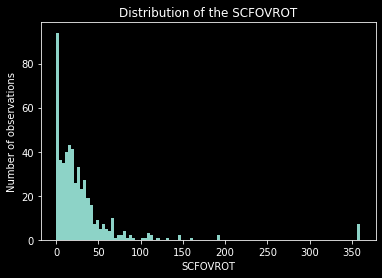

In [5]:
# Plot histogram of the wanted headers
hist_list = ['SCFOVROT']

for hist in hist_list:
    try:
        plt.hist(df[hist], bins=100)
        plt.title("Distribution of the {}".format(hist))
        plt.xlabel(hist)
        plt.ylabel("Number of observations")
        plt.show()
    except KeyError:
        print("ERROR! Header {} does not exist.".format(hist))

In [6]:
# Print the types of the columns
print(df.dtypes)

folder                            object
ESO OBS ID                         int64
DATE-OBS                          object
OBJECT                            object
ESO TEL AMBI FWHM MEAN           float64
ESO TEL TAU0 MEAN                float64
ESO TEL AIRM MEAN                float64
EFF_NFRA                         float64
EFF_ETIM                         float64
SR_AVG                           float64
ESO INS4 FILT3 NAME               object
ESO INS4 OPTI22 NAME              object
ESO AOS VISWFS MODE               object
ESO TEL AMBI WINDSP              float64
SCFOVROT                         float64
SC MODE                           object
ESO TEL AMBI RHUM                float64
HIERARCH ESO INS4 TEMP422 VAL    float64
HIERARCH ESO TEL TH M1 TEMP      float64
HIERARCH ESO TEL AMBI TEMP       float64
SEPARATION                        object
NSIGMA_CONTRAST                   object
SIMBAD_FLUX_G                    float64
SIMBAD_FLUX_H                    float64
dtype: object


This plot is a summary plot of all the contrast curves, no anomaly detection has been performed.

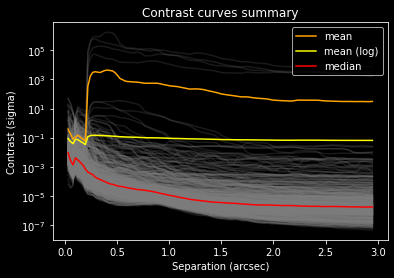

In [7]:
plot_contrast_curves_summary(path_db, df, filename='contrast_curves_summary_raw.png')

Now the sum of the absolute differences between the contrast curves and the median contrast curve (using log values) is used as deviation measure.

In [8]:
df['ABS DEV'] = get_abs_deviations_from_median(df)
# df

The distribution of these deviations is showed and some outliers can be observed.

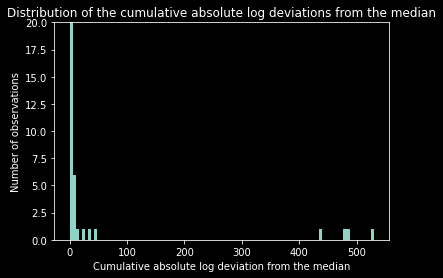

In [9]:
# Plot the distribution of the absolute deviations from the median
plt.hist(df['ABS DEV'], bins=100)	
# plt.xlim(0, 100)
plt.ylim(0, 20)
plt.title("Distribution of the cumulative absolute log deviations from the median")
plt.xlabel("Cumulative absolute log deviation from the median")
plt.ylabel("Number of observations")
plt.show()

The cut-off criterion has been chosen (arbitrarly) and a new summary plot has been computed in order to be compared to the previous one.

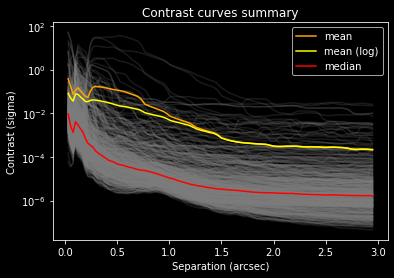

In [10]:
df_AD = remove_contrast_anomalies(path_db, df, threshold=100)

# Plot the new summary of the contrast curves
plot_contrast_curves_summary(path_db, df_AD, filename='contrast_curves_summary_anomaly_detection.png')

In [11]:
df_AD

,folder,ESO OBS ID,DATE-OBS,OBJECT,ESO TEL AMBI FWHM MEAN,ESO TEL TAU0 MEAN,ESO TEL AIRM MEAN,EFF_NFRA,EFF_ETIM,SR_AVG,...,SC MODE,ESO TEL AMBI RHUM,HIERARCH ESO INS4 TEMP422 VAL,HIERARCH ESO TEL TH M1 TEMP,HIERARCH ESO TEL AMBI TEMP,SEPARATION,NSIGMA_CONTRAST,SIMBAD_FLUX_G,SIMBAD_FLUX_H,ABS DEV
0,++ CVN 3B_DB_H23_2018-09-14_ird_specal_dc_cADI...,2177825,2018-09-15T07:33:22.600,CD-52 381,1.262950,0.002073,1.14378,3360.0,2813.00,0.568267,...,CADI,4.5,11.1,7.48,7.24,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.0764733002369364, 0.007057913887455397, 0.0...",10.614176,8.530,0.034402
1,++ KOH 78_DB_H23_2016-04-03_ird_specal_dc_cADI...,1182440,2016-04-04T07:59:57.849,ScoPMS_048,NaN,NaN,NaN,NaN,NaN,0.612498,...,CADI,36.5,15.9,12.55,13.33,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.013610598683677744, 0.005102142635421004, 0...",14.683154,8.473,0.004896
2,++ SKF 1501_DB_H23_2015-04-11_ird_specal_dc_cA...,1182371,2015-04-12T07:15:49.844,HIP_76629,NaN,NaN,NaN,NaN,NaN,NaN,...,CADI,8.5,17.3,14.33,15.94,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.00835001855564525, 0.0022740225957848703, 0...",7.677120,5.994,0.005167
3,1RXS J184646.0-363621_DB_H23_2018-07-04_ird_sp...,1962017,2018-07-05T01:24:56.950,RXJ1846,2.310000,0.001700,1.35900,32.0,26.79,0.203250,...,CADI,33.0,10.7,7.45,8.43,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.12483872406837707, 0.07288618737488416, 0.0...",10.789814,8.469,4.846991
4,1RXS J184646.0-363621_DB_H23_2018-07-04_ird_sp...,1962017,2018-07-05T01:24:56.950,RXJ1846,2.310000,0.001700,1.35900,32.0,26.79,0.203250,...,CADI,33.0,10.7,7.45,8.43,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.12483872406837707, 0.07288618737488416, 0.0...",10.789814,8.469,4.846991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,TYC 7692-2943-2_DB_H23_2019-03-19_ird_specal_d...,2296758,2019-03-20T02:23:21.230,TYC 7692-2943-2,0.770000,0.005300,1.03000,16.0,512.00,-1.000000,...,CADI,20.0,15.5,12.81,14.74,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.010639848856919395, 0.002414968575376793, 0...",9.348000,NaN,0.003894
510,TYC 7692-2943-2_DB_H23_2019-03-24_ird_specal_d...,2296758,2019-03-25T02:18:36.930,TYC 7692-2943-2,0.670000,0.009100,1.03000,63.0,2016.00,-1.000000,...,CADI,19.0,16.0,12.87,15.12,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.007000685686163963, 0.002920603859616869, 0...",9.348000,NaN,0.005883
511,TYC 8092-1574-2_DB_H23_2016-10-01_ird_specal_d...,1424674,2016-10-02T08:50:23.156,HIP 28153,NaN,NaN,NaN,NaN,NaN,0.624970,...,CADI,4.5,15.9,12.40,13.66,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.007665507957330054, 0.000964130643938169, 0...",12.476170,NaN,0.019931
512,TYC 8097-337-1_DB_H23_2018-10-31_ird_specal_dc...,2028801,2018-11-01T07:33:29.100,TYC 8097-337-1,0.560000,0.006600,1.12000,64.0,4096.00,0.714905,...,CADI,11.0,16.5,12.78,14.60,"[0.0306249987334013, 0.05435055188410651, 0.07...","[0.006814450366733455, 0.0032717083575035423, ...",11.274122,9.907,0.004753
